# Reference points

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [53]:
from pathlib import Path
import pickle
import sys

import matplotlib.pyplot as plt
import pandas as pd
import scipy

from kinsim_structure.auxiliary import KlifsMoleculeLoader, PdbChainLoader
from kinsim_structure.encoding import Fingerprint, PhysicoChemicalFeatures, SpatialFeatures
from kinsim_structure.encoding import PharmacophoreSizeFeatures, SideChainOrientationFeature, ExposureFeature

In [4]:
pd.set_option('display.max_rows', 100)

## IO paths

In [5]:
path_to_data = Path('/') / 'home' / 'dominique' / 'Documents' / 'data' / 'kinsim' / '20190724_full'
path_to_kinsim = Path('/') / 'home' / 'dominique' / 'Documents' / 'projects' / 'kinsim_structure'
path_to_results = path_to_kinsim / 'results'

metadata_path = path_to_data / 'postprocessed' / 'klifs_metadata_postprocessed.csv'

## Load metadata

In [6]:
klifs_metadata = pd.read_csv(metadata_path)

## Reference point distances within a molecule

In [ ]:
#!python ../scripts/reference_points.py

In [44]:
distances_list = []

for index, row in klifs_metadata[:10].iterrows():
    
    ml = KlifsMoleculeLoader(klifs_metadata_entry=entry)
    spatial = SpatialFeatures()
    spatial.from_molecule(ml.molecule)
   
    distances = scipy.linalg.norm(
        spatial.reference_points.apply(lambda x: x - spatial.reference_points.centroid), 
        axis=0
    )
    
    distances_list.append(distances)
    
distances_list

[array([0.        , 5.52810282, 6.80243263, 6.14273006]),
 array([0.        , 5.52810282, 6.80243263, 6.14273006]),
 array([0.        , 5.52810282, 6.80243263, 6.14273006]),
 array([0.        , 5.52810282, 6.80243263, 6.14273006]),
 array([0.        , 5.52810282, 6.80243263, 6.14273006]),
 array([0.        , 5.52810282, 6.80243263, 6.14273006]),
 array([0.        , 5.52810282, 6.80243263, 6.14273006]),
 array([0.        , 5.52810282, 6.80243263, 6.14273006]),
 array([0.        , 5.52810282, 6.80243263, 6.14273006]),
 array([0.        , 5.52810282, 6.80243263, 6.14273006])]

In [47]:
distances_df = pd.DataFrame(
    distances_list, 
    columns='centroid_to_centroid, centroid_to_hinge centroid_to_dfg centroid_to_front'.split()
)
distances_df.reset_index(inplace=True)

ref2ref_distances = klifs_metadata[:10].copy()
ref2ref_distances.reset_index(inplace=True)


result = pd.concat([ref2ref_distances, distances_df], axis=1)

In [48]:
result

,level_0,Unnamed: 0,index,kinase,family,groups,pdb_id,chain,alternate_model,species,...,pocket,resolution,missing_residues,missing_atoms,full_ifp,index,"centroid_to_centroid,",centroid_to_hinge,centroid_to_dfg,centroid_to_front
0,0,0,2886,AAK1,NAK,Other,4wsq,B,A,Human,...,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.95,0,14,0000000000000010000001000000000000000000000000...,0,0.0,5.528103,6.802433,6.14273
1,1,1,10043,AAK1,NAK,Other,5l4q,A,A,Human,...,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.97,0,3,0000000000000010000000000000000000000000000000...,1,0.0,5.528103,6.802433,6.14273
2,2,2,7046,AAK1,NAK,Other,5te0,A,-,Human,...,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.90,0,12,1000101000000010000001000000000000000000000000...,2,0.0,5.528103,6.802433,6.14273
3,3,3,843,ABL1,Abl,TK,2f4j,A,-,Human,...,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.91,0,0,0000000000000010000001000000000000000000000000...,3,0.0,5.528103,6.802433,6.14273
4,4,4,815,ABL1,Abl,TK,2g1t,A,-,Human,...,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.80,0,0,NaN,4,0.0,5.528103,6.802433,6.14273
5,5,5,859,ABL1,Abl,TK,2g2i,A,-,Human,...,HKLGGG___EVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,3.12,3,0,0000000000000010000001000000000000000000000000...,5,0.0,5.528103,6.802433,6.14273
6,6,6,816,ABL1,Abl,TK,2gqg,A,B,Human,...,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.40,0,0,0000000000000010000000000000000000000000000000...,6,0.0,5.528103,6.802433,6.14273
7,7,7,807,ABL1,Abl,TK,2hz4,B,-,Human,...,HKLG_____EVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,2.80,5,0,0000000000000010000000000000000000000000000000...,7,0.0,5.528103,6.802433,6.14273
8,8,8,832,ABL1,Abl,TK,2v7a,B,-,Human,...,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIIIE...,2.50,0,0,0000000000000010000000000000100000010000000000...,8,0.0,5.528103,6.802433,6.14273
9,9,9,829,ABL1,Abl,TK,4twp,B,-,Human,...,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIIIE...,2.40,0,0,0000000000000010000001000000000000000000000000...,9,0.0,5.528103,6.802433,6.14273


In [64]:
result = pd.read_csv(path_to_results / 'ref2ref_distances.p')

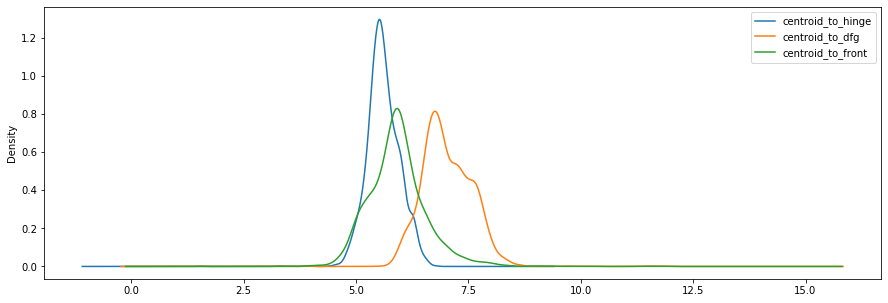

In [66]:
result['centroid_to_hinge centroid_to_dfg centroid_to_front'.split()].plot(
    kind='density',
    figsize=(15,5)
)

5.5281028195393995

In [67]:
klifs_metadata[klifs_metadata.pdb_id=='3w32']

,Unnamed: 0,index,kinase,family,groups,pdb_id,chain,alternate_model,species,ligand_orthosteric_name,...,dfg,ac_helix,rmsd1,rmsd2,qualityscore,pocket,resolution,missing_residues,missing_atoms,full_ifp
1502,1510,604,EGFR,EGFR,TK,3w32,A,-,Human,4-({3-chloro-4-[3-(trifluoromethyl)phenoxy]phe...,...,in,out,0.83,2.177,8.0,KVLGSGAFGTVYKVAIKELEILDEAYVMASVDPHVCRLLGIQLITQ...,1.8,0,0,0000000000000010000001000000000000000000000000...
